In [1]:
import pandas as pd
import numpy as np

In [2]:
# This will allow you to see all column names & rows when you are doing .head(). None of the column name will be truncated.
# source: https://stackoverflow.com/questions/49188960/how-to-show-all-of-columns-name-on-pandas-dataframe

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
# source: https://gist.github.com/rozanecm/38f2901c592bdffc40726cb0473318cf
# Function which plays a beep of given duration and frequency.
# Useful for when executing things that need a while to finish, to get notified.
import os
def beep(duration = 0.6, freq = 200):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [4]:
train = pd.read_csv('../data/train_full.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])

In [5]:
test = pd.read_csv('../data/test_full.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])

In [6]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

El sample submission no tiene header. **Ojo con eso al guardar la submission.** Hagamos la funcion para guardar submissions ahora, para evitar problemas a futuro y despreocuparnos.

In [7]:
# To save predictions.
# There must be a directory ../predictions for this to work as expected.
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
import time
def _get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def _save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name="fcozza", description = "no description.", index=False, header=True):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(_get_filename(authors_name, timestamp), index=index, header=header)
    _save_description(authors_name, timestamp, description)

***

# Approach 1.1 - XGBoost con CV basico solo features de matriz de correlacion(Grid Search)

- https://towardsdatascience.com/feature-selection-for-machine-learning-1-2-1597d9ccb54a 
- https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [35]:
X_train = X_train[['gimnasio','usosmultiples','piscina','cant_palabras_positivas','cant_areas_verdes','tiene_bodega',\
                'tiene_servicio','tiene_seguridad','banos','garages','habitaciones','metroscubiertos','metrostotales','year',\
                ]]

In [37]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params = {  
    "n_estimators": [200],
    "max_depth": [20,22,25],
    "learning_rate": [0.06], 
    "colsample_bytree": [1],
    "subsample": [0.946934], 
    "gamma":[30],
    'reg_alpha': [10],
    "min_child_weight": [11]
}

regXGB = xgb.XGBRegressor(objective ='reg:squarederror',nthread=-1) 

regXGBwithCV = GridSearchCV(regXGB, params, n_jobs=-1,verbose=10,cv=3) # n_iters es la cant de veces que busca, 10 es lo default

regXGBwithCV.fit(X_train, y_train, eval_metric="rmse")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  2.1min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  2.1min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.2min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  2.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  2.4min remaining:   41.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.3min finished
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_stat...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [1], 'gamma': [30],
                         'learning_rate': [0.06], 'max_depth': [20, 22, 25],
      

In [38]:
print(regXGBwithCV.best_score_)
print(regXGBwithCV.best_params_)

0.568280850314891
{'colsample_bytree': 1, 'gamma': 30, 'learning_rate': 0.06, 'max_depth': 20, 'min_child_weight': 11, 'n_estimators': 200, 'reg_alpha': 10, 'subsample': 0.946934}


 No sirve

# Approach 1.2 - XGBoost con CV basico solo features de BoostARoota (Grid Search)

- https://github.com/chasedehan/BoostARoota

In [23]:
X_train = X_train[['gimnasio','usosmultiples','centroscomercialescercanos','cant_palabras_positivas','cant_areas_dedicadas',\
                   'cant_areas_verdes','cant_areas_entretenimiento_cerca','planta_alta','planta_baja','tiene_bodega',\
                   'comercial','tiene_servicio','edificio','casa','usa_easybroker','tiene_seguridad','tiene_antiguedad',\
                   'antiguedad','tiene_banos','banos','tiene_garages','garages','tiene_habitaciones','habitaciones',\
                   'tiene_metroscubiertos','metroscubiertos','tiene_metrostotales','metrostotales','cant_amenities','year',\
                   'sin_month','sin_day'
                ]]

In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

params = {  
    "n_estimators": [200],
    "max_depth": [20,22,25],
    "learning_rate": [0.06], 
    "colsample_bytree": [1],
    "subsample": [0.946934], 
    "gamma":[30],
    'reg_alpha': [10],
    "min_child_weight": [11]
}

regXGB = xgb.XGBRegressor(objective ='reg:squarederror',nthread=-1) 

regXGBwithCV = GridSearchCV(regXGB, params, n_jobs=-1,verbose=10,cv=3) # n_iters es la cant de veces que busca, 10 es lo default

regXGBwithCV.fit(X_train, y_train, eval_metric="rmse")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  3.8min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  3.8min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  4.1min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  4.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  4.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  4.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.6min finished
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:squarederror',
                                    random_stat...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [1], 'gamma': [30],
                         'learning_rate': [0.06], 'max_depth': [20, 22, 25],
      

In [25]:
print(regXGBwithCV.best_score_)
print(regXGBwithCV.best_params_)

0.6387103697028009
{'colsample_bytree': 1, 'gamma': 30, 'learning_rate': 0.06, 'max_depth': 20, 'min_child_weight': 11, 'n_estimators': 200, 'reg_alpha': 10, 'subsample': 0.946934}


No sirve

# Approach 1.3 - XGBoost con CV y todos los features (categorical encoding 1 - label encoding) (Random Search)

- https://medium.com/@songxia.sophia/two-machine-learning-algorithms-to-predict-xgboost-neural-network-with-entity-embedding-caac68717dea

In [55]:
import re
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [71]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [72]:
encode_columns = ['ciudad', 'tipodepropiedad', 'provincia']

In [73]:
encode_df = X[encode_columns]
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)

In [74]:
score_encode_drop = X.drop(encode_columns, axis = 1)
score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(score_encode, y, test_size=0.33, random_state=seed)

In [76]:
X_train = X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1)

In [77]:
params = {"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(100, 250), # default 100
          "subsample": uniform(0.6, 0.4)}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)

time_split = TimeSeriesSplit(n_splits = 8)

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=seed,\
                                n_iter=4, cv=time_split, verbose=1, n_jobs=-1, return_train_score=True)

In [78]:
%%time
xgb_search.fit(X_train, y_train, eval_metric="rmse")

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  2.1min finished
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CPU times: user 36.9 s, sys: 324 ms, total: 37.2 s
Wall time: 2min 40s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27bfc9f828>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27c9150e48>,
  

In [79]:
print(xgb_search.best_score_)
print(xgb_search.best_params_)

0.7770412558172045
{'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.2628528437324805, 'max_depth': 5, 'n_estimators': 203, 'subsample': 0.8832290311184181}


In [80]:
X_test = X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1)

In [81]:
y_pred = xgb_search.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))
print ('RMSE:', rms)

RMSE: 977271.2515415936


In [82]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [83]:
X = train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'], axis=1) #set de datos
y = train['precio'] #target

In [84]:
encode_columns = ['ciudad', 'tipodepropiedad', 'provincia']

In [85]:
encode_df = X[encode_columns]
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)

In [86]:
score_encode_drop = X.drop(encode_columns, axis = 1)
score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)

In [88]:
%%time
#Entrenar modelo
model = xgb.XGBRegressor(colsample_bytree=0.7467983561008608,gamma=0.02904180608409973,learning_rate=0.2628528437324805,max_depth=5,n_estimators=203,\
                 subsample=0.8832290311184181,nthread=-1,objective ='reg:squarederror')

model.fit(score_encode, y,eval_metric="rmse", verbose=True)

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


CPU times: user 56 s, sys: 240 ms, total: 56.2 s
Wall time: 56.2 s


In [97]:
test_to_encode = test.drop(['id','fecha','titulo', 'descripcion', 'direccion'], axis=1)

In [98]:
encode_df_test = test_to_encode[encode_columns]
encode_df_test = encode_df_test.astype('str')
encode_df_test = encode_df_test.apply(LabelEncoder().fit_transform)

In [91]:
score_encode_drop_test = test_to_encode.drop(encode_columns, axis = 1)
score_encode_test = pd.concat([score_encode_drop_test, encode_df_test], axis = 1)

In [92]:
pred = model.predict(score_encode_test)

In [94]:
df = pd.DataFrame(data={'id':test['id'], 'target':pred})

In [95]:
description = "1st approach_full_features. XGBoost"
save_submission(df, description=description)

In [96]:
beep()

***

# Approach 1.4 - XGBoost con CV y todos los features (categorical encoding 2) (Random Search)

- https://medium.com/@songxia.sophia/two-machine-learning-algorithms-to-predict-xgboost-neural-network-with-entity-embedding-caac68717dea

In [84]:
import re
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

In [85]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [86]:
onehot_columns = ['ciudad', 'tipodepropiedad', 'provincia']

In [87]:
onehot_df = pd.get_dummies(X, columns = onehot_columns)
score_onehot_drop = X.drop(onehot_columns, axis = 1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis = 1)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(score_onehot, y, test_size=0.33, random_state=seed)

In [89]:
X_train = X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1)

In [90]:
params = {"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(100, 250), # default 100
          "subsample": uniform(0.6, 0.4)}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)

time_split = TimeSeriesSplit(n_splits = 8)

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=seed,\
                                n_iter=4, cv=time_split, verbose=1, n_jobs=-1, return_train_score=True)

In [91]:
X_train = X_train.loc[:,~X_train.columns.duplicated()]

In [159]:
%%time
xgb_search.fit(X_train, y_train, eval_metric="rmse")

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

## One hot cuelga la pc con las dimensiones, habra que achicarlas

Basado en el approach 2 de Matias en first approaches by rozanecm uso lo siguiente:

In [92]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [94]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

params = {"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(100, 250), # default 100
          "subsample": uniform(0.6, 0.4)}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=seed)

time_split = TimeSeriesSplit(n_splits = 8)

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=seed,\
                                n_iter=4, cv=time_split, verbose=1, n_jobs=-1, return_train_score=True)

In [95]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day','cant_comodidades_en_desc',
    'cant_amenities','cant_lugares_cerca','cant_areas_entretenimiento_cerca',
    'cant_areas_verdes','cant_areas_dedicadas','cant_palabras_positivas']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida',
               'planta_alta','planta_baja','tiene_bodega','oficina','cerca_o_en_esquina','cerca_o_en_avenida',
               'comercial','tiene_servicio','edificio','casa','parte_de_lote','calle_cerrada',
               'indica_frente_y_fondo','usa_easybroker','tiene_seguridad','tiene_antiguedad','tiene_banos',
               'tiene_garages','tiene_habitaciones','tiene_metroscubiertos','tiene_metrostotales']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_random_search", xgb_search))

my_pipe = Pipeline(steps, verbose=True)

In [96]:
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   7.3s
Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  3.4min finished


[Pipeline]  (step 2 of 2) Processing xgboost_random_search, total= 4.7min
610214.3501041636


In [97]:
beep()

## Entrenamiento con todos los datos para obtener predicciones a subir

In [98]:
del X_train
del X_test
del y_train
del y_test

In [100]:
my_pipe.fit(train.drop(['precio'], axis=1).replace({True:1,False:0}), train['precio'])

# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

In [109]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [110]:
description = "1st approach_full_features. XGBoost con one hot"
save_submission(df, description=description)

In [ ]:
beep()

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [102]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1_4"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

TRAIN: [     1      2      3 ... 239995 239996 239997] TEST: [     0      4      6 ... 239991 239998 239999]
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.4s


ValueError: Found input variables with inconsistent numbers of samples: [160000, 301176]

In [27]:
beep()

***

# Approach 1.5 - XGBoost parameter tunning (Grid Search)

- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [38]:
import re
import time
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

In [39]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Tunning max depth y min child weight

In [54]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model,param_grid = param_test1,n_jobs=-1,iid=False, cv=5)

In [55]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day','cant_comodidades_en_desc',
    'cant_amenities','cant_lugares_cerca','cant_areas_entretenimiento_cerca',
    'cant_areas_verdes','cant_areas_dedicadas','cant_palabras_positivas']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida',
               'planta_alta','planta_baja','tiene_bodega','oficina','cerca_o_en_esquina','cerca_o_en_avenida',
               'comercial','tiene_servicio','edificio','casa','parte_de_lote','calle_cerrada',
               'indica_frente_y_fondo','usa_easybroker','tiene_seguridad','tiene_antiguedad','tiene_banos',
               'tiene_garages','tiene_habitaciones','tiene_metroscubiertos','tiene_metrostotales']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search1", gsearch1))

my_pipe = Pipeline(steps, verbose=True)

In [56]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  11.0s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_grid_search1, total=17.1min
573755.0267781329
CPU times: user 1min 44s, sys: 1.07 s, total: 1min 45s
Wall time: 17min 23s


In [60]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 5}, 0.8073939828312875)

In [61]:
beep()

Tunning mas preciso sobre este tunning

In [62]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = xgb_model,param_grid = param_test2, n_jobs=-1,iid=False, cv=5)

In [63]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search1", gsearch2))

my_pipe = Pipeline(steps, verbose=True)

In [64]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   9.6s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_grid_search1, total=19.6min
CPU times: user 1min 56s, sys: 889 ms, total: 1min 57s
Wall time: 19min 44s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [65]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 10, 'min_child_weight': 6}, 0.8090391201801971)

In [66]:
beep()

Valores mayores

In [68]:
param_test2b = {
 'max_depth':[9,10,11,12],
 'min_child_weight':[6,8,10,12]
}

gsearch2b = GridSearchCV(estimator = xgb_model,param_grid = param_test2b, n_jobs=-1,iid=False, cv=5)

In [69]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch2b))

my_pipe = Pipeline(steps, verbose=True)

In [70]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   7.2s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=39.5min
CPU times: user 1min 57s, sys: 1.32 s, total: 1min 58s
Wall time: 39min 38s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [77]:
gsearch2b.best_params_, gsearch2b.best_score_

({'max_depth': 10, 'min_child_weight': 6}, 0.8090391201801971)

In [72]:
beep()

Entonces 10 y 6 son optimos

## Tunning gamma

In [78]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

xgb_model = xgb.XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch3 = GridSearchCV(estimator = xgb_model,param_grid = param_test3, n_jobs=-1,iid=False, cv=5)

In [79]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch3))

my_pipe = Pipeline(steps, verbose=True)

In [80]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   4.8s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=14.0min
CPU times: user 1min 57s, sys: 3.08 s, total: 2min
Wall time: 15min 43s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [81]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.8090391201801971)

In [82]:
beep()

## Tunning subsample and colsample_bytree

In [94]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_model = xgb.XGBRegressor( learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch4 = GridSearchCV(estimator = xgb_model,param_grid = param_test4, n_jobs=-1,iid=False, cv=5)

In [95]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch4))

my_pipe = Pipeline(steps, verbose=True)

In [96]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   9.8s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=50.1min
CPU times: user 2min 21s, sys: 1.54 s, total: 2min 22s
Wall time: 50min 19s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [97]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, 0.8117147682581691)

In [98]:
beep()

Mas preciso

In [99]:
param_test5 = {
 'subsample':[i/100.0 for i in range(80,100,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

xgb_model = xgb.XGBRegressor( learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch5 = GridSearchCV(estimator = xgb_model,param_grid = param_test5, n_jobs=-1,iid=False, cv=5)

In [100]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch5))

my_pipe = Pipeline(steps, verbose=True)

In [101]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  11.2s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=35.2min
CPU times: user 2min 17s, sys: 1.44 s, total: 2min 19s
Wall time: 35min 26s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [102]:
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.95}, 0.8121743836444513)

In [103]:
beep()

## Tunning reg_alpha

In [104]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch6 = GridSearchCV(estimator = xgb_model,param_grid = param_test6, n_jobs=-1,iid=False, cv=5)

In [105]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch6))

my_pipe = Pipeline(steps, verbose=True)

In [106]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.2s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=18.6min
CPU times: user 2min 17s, sys: 772 ms, total: 2min 18s
Wall time: 18min 40s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [107]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1}, 0.8123286654703807)

In [108]:
beep()

Mas preciso

In [109]:
param_test7 = {
 'reg_alpha':[0.5, 0.75, 1, 1.25, 1.5, 2]
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch7 = GridSearchCV(estimator = xgb_model,param_grid = param_test7, n_jobs=-1,iid=False, cv=5)

In [110]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch7))

my_pipe = Pipeline(steps, verbose=True)

In [111]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  10.0s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=18.2min
CPU times: user 2min 17s, sys: 1.67 s, total: 2min 19s
Wall time: 18min 25s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [112]:
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 1.5}, 0.8123413160129532)

In [113]:
beep()

## Tunning n_estimators

In [116]:
param_test8 = {
 'n_estimators':[100, 150, 200, 250, 300]
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             reg_alpha=1.5,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch8 = GridSearchCV(estimator = xgb_model,param_grid = param_test8, n_jobs=-1,iid=False, cv=5)

In [117]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch8))

my_pipe = Pipeline(steps, verbose=True)

In [118]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=  12.5s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=17.4min
CPU times: user 3min 18s, sys: 1.61 s, total: 3min 20s
Wall time: 17min 42s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [119]:
gsearch8.best_params_, gsearch8.best_score_

({'n_estimators': 300}, 0.8136330892288279)

In [120]:
beep()

In [121]:
param_test9 = {
 'n_estimators':[300, 500, 700, 900, 1200]
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             reg_alpha=1.5,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch9 = GridSearchCV(estimator = xgb_model,param_grid = param_test9, n_jobs=-1,iid=False, cv=5)

In [122]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch9))

my_pipe = Pipeline(steps, verbose=True)

In [123]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   9.0s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=57.2min
CPU times: user 9min 29s, sys: 1.59 s, total: 9min 31s
Wall time: 57min 24s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [124]:
gsearch9.best_params_, gsearch9.best_score_

({'n_estimators': 900}, 0.8151624288480696)

In [125]:
beep()

## Tunning learning_rate

In [130]:
param_test10 = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             reg_alpha=1.5,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch10 = GridSearchCV(estimator = xgb_model,param_grid = param_test10, n_jobs=-1,iid=False, cv=5)

In [131]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch10))

my_pipe = Pipeline(steps, verbose=True)

In [132]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.9s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=13.2min
CPU times: user 2min 16s, sys: 1.44 s, total: 2min 17s
Wall time: 13min 17s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [133]:
gsearch10.best_params_, gsearch10.best_score_

({'learning_rate': 0.1}, 0.8123413160129532)

In [134]:
beep()

In [135]:
param_test11 = {
 'learning_rate':[0.075, 0.085, 0.095, 0.1, 0.15]
}

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             reg_alpha=1.5,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

gsearch11 = GridSearchCV(estimator = xgb_model,param_grid = param_test11, n_jobs=-1,iid=False, cv=5)

In [136]:
steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_grid_search", gsearch11))

my_pipe = Pipeline(steps, verbose=True)

In [137]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   4.1s
[Pipeline]  (step 2 of 2) Processing xgboost_grid_search, total=16.9min
CPU times: user 2min 16s, sys: 1.17 s, total: 2min 18s
Wall time: 17min 2s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [138]:
gsearch11.best_params_, gsearch11.best_score_

({'learning_rate': 0.1}, 0.8123413160129532)

In [139]:
beep()

### Entrenamiento local

In [176]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [178]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             reg_alpha=1.5,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

In [179]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day','cant_comodidades_en_desc',
    'cant_amenities','cant_lugares_cerca','cant_areas_entretenimiento_cerca',
    'cant_areas_verdes','cant_areas_dedicadas','cant_palabras_positivas']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida',
               'planta_alta','planta_baja','tiene_bodega','oficina','cerca_o_en_esquina','cerca_o_en_avenida',
               'comercial','tiene_servicio','edificio','casa','parte_de_lote','calle_cerrada',
               'indica_frente_y_fondo','usa_easybroker','tiene_seguridad','tiene_antiguedad','tiene_banos',
               'tiene_garages','tiene_habitaciones','tiene_metroscubiertos','tiene_metrostotales']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_best_params", xgb_model))

my_pipe = Pipeline(steps, verbose=True)

In [168]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.7s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_best_params, total=  32.0s
565678.6317656053
CPU times: user 4min 15s, sys: 1.78 s, total: 4min 17s
Wall time: 38.1 s


## Entrenamiento con todos los datos para obtener predicciones a subir

In [180]:
del X_train
del X_test
del y_train
del y_test

In [181]:
my_pipe.fit(X.replace({True:1,False:0}), y)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.7s
[Pipeline]  (step 2 of 2) Processing xgboost_best_params, total=  47.1s


Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [182]:
# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

In [183]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [184]:
description = "1st approach_full_features. XGBoost with tunning parameters with missing column of feat desc"
save_submission(df, description=description)

In [185]:
beep()

## Obtengamos predicciones para todas las propiedades en nuestro train set

In [186]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_1"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    my_pipe.fit(X_train2.replace({True:1,False:0}), y_train2)
    y_scores = my_pipe.predict(X_test2.replace({True:1,False:0}))
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.8s
[Pipeline]  (step 2 of 2) Processing xgboost_best_params, total=  31.0s
562156.9611009766
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.7s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_best_params, total=  31.3s
564242.0440959473
[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.8s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[Pipeline]  (step 2 of 2) Processing xgboost_best_params, total=  30.7s
561763.8883504883


In [187]:
beep()

***

# Approach 1.6 - XGBoost optimum parameters + log precio

In [157]:
train['precio_log'] = np.log(train['precio'])

In [158]:
X = train.drop(['precio', 'precio_log'], axis=1) #set de datos
y = train['precio_log'] #target

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [160]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                             min_child_weight=6, gamma=0, subsample=0.95, colsample_bytree=0.7,
                             reg_alpha=1.5,
                             objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27)

In [161]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day','cant_comodidades_en_desc',
    'cant_amenities','cant_lugares_cerca','cant_areas_entretenimiento_cerca',
    'cant_areas_verdes','cant_areas_dedicadas','cant_palabras_positivas']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida',
               'planta_alta','planta_baja','tiene_bodega','oficina','cerca_o_en_esquina','cerca_o_en_avenida',
               'comercial','tiene_servicio','edificio','casa','parte_de_lote','calle_cerrada',
               'indica_frente_y_fondo','usa_easybroker','tiene_seguridad','tiene_antiguedad','tiene_banos',
               'tiene_garages','tiene_habitaciones','tiene_metroscubiertos','tiene_metrostotales']

text_columns = ['titulo'
#                 ,'descripcion'
#                 ,'direccion'
               ]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("xgboost_best_params", xgb_model))

my_pipe = Pipeline(steps, verbose=True)

In [162]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   9.0s


/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 

In [163]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

1718557.9961227942


# Approach 2: LightGBM optimizado with log price + features desc

## Entrenamiento local

In [8]:
train['precio_log'] = np.log(train['precio'])

In [9]:
X = train.drop(['precio', 'precio_log'], axis=1) #set de datos
y = train['precio_log'] #target

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [11]:
import lightgbm as lgb

gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                  importance_type='split', learning_rate=0.05, max_depth=75,
                                  min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                                  n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
                                  random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                                  subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [12]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.21067419127689918


In [13]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

519099.9153115991


In [12]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.21065318571960145


In [13]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

518785.0102593847


## Entrenamiento con todos los datos para obtener predicciones a subir

In [14]:
%%time
gbm_optimized.fit(X.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 3min 12s, sys: 1.05 s, total: 3min 13s
Wall time: 25.5 s


In [15]:
exp_predictions = np.exp(predictions)

In [16]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [195]:
description = "2nd approach. LightGBM previous grid search. Log(precio) y features descripcion con la columna faltante"
save_submission(df, description=description)

In [17]:
description = "7th approach. LightGBM previous grid search. Log(precio) y new features + ambos clustering"
save_submission(df, description=description)

In [196]:
beep()

## Obtengamos predicciones para todas las propiedades en nuestro train set

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_2"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.21385317943632895
525985.5965540847
0.21456159327952815
531013.6982330559
0.21467270170598998
527230.3555496839


# Approach 2.1: LightGBM with log price + features desc (grid search con nuevos features)

## Entrenamiento local

In [35]:
train['precio_log'] = np.log(train['precio'])

In [36]:
X = train.drop(['precio', 'precio_log'], axis=1) #set de datos
y = train['precio_log'] #target

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [39]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(silent=False)

param_dist = {"boosting_type":['gbdt','dart'],
              "max_depth": [25,50,75],
              "learning_rate" : [0.001,0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [50,100,200],
             }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(X.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y)
grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 67.3min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=25,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

gbm_optimized = grid_search.best_estimator_

In [41]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.21345376777287184


In [42]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

525219.9818594557


## Entrenamiento con todos los datos para obtener predicciones a subir

In [43]:
%%time
gbm_optimized.fit(X.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [44]:
exp_predictions = np.exp(predictions)

In [45]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [46]:
description = "2.1 approach. LightGBM with new grid search for new features of desc. Log(precio)"
save_submission(df, description=description)

In [47]:
beep()

# Approach 3: Test promedio LightGBM + XGBoost

In [46]:
predictions_xgboost = pd.read_csv('../predictions/2019.11.27 - 01:34:19 by fcozza.csv')
predictions_lightgbm = pd.read_csv('../predictions/2019.11.27 - 02:14:16 by fcozza.csv')

## Promedio las predicciones

In [47]:
pred = pd.merge(predictions_xgboost,predictions_lightgbm,on='id',how='inner')

In [50]:
pred['target'] = (pred['target_x'] + pred['target_y']) / 2

In [52]:
pred = pred [['id','target']]

In [53]:
description = "3rd approach. Promedio entre xgboost y lightgbm"
save_submission(pred,description=description)

## No mejoró

# Approach 4: Red neuronal con Keras

- https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
- https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [18]:
train['precio_log'] = np.log(train['precio'])

In [19]:
X = train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio', 'precio_log'], axis=1) #set de datos
y = train['precio_log'] #target

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [22]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [23]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# define base model
def baseline_model():
    NN_model = Sequential()
    
    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 83, activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='softmax'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='sigmoid'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return NN_model

In [43]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [44]:
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

In [45]:
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
small_size_cat_columns = ['tipodepropiedad','provincia']
large_size_cat_columns = ['ciudad']

num_columns = [
#     'id',
    "antiguedad","habitaciones",'garages',
    'banos','metroscubiertos', 'metrostotales','idzona',
    'lat', 'lon', 'cant_amenities',
    'year','sin_month','cos_month', 'sin_day', 'cos_day','cant_comodidades_en_desc',
    'cant_amenities','cant_lugares_cerca','cant_areas_entretenimiento_cerca',
    'cant_areas_verdes','cant_areas_dedicadas','cant_palabras_positivas']

bool_columns = ['gimnasio','usosmultiples','piscina','escuelascercanas','centroscomercialescercanos','es_avenida',
               'planta_alta','planta_baja','tiene_bodega','oficina','cerca_o_en_esquina','cerca_o_en_avenida',
               'comercial','tiene_servicio','edificio','casa','parte_de_lote','calle_cerrada',
               'indica_frente_y_fondo','usa_easybroker','tiene_seguridad','tiene_antiguedad','tiene_banos',
               'tiene_garages','tiene_habitaciones','tiene_metroscubiertos','tiene_metrostotales']

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import mean_absolute_error

transformers = []

transformers.append(("small_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=11, n_iter=7, random_state=seed))
                     ]),
                     small_size_cat_columns))

transformers.append(("large_cat",
                     Pipeline(steps=[
                         ("category_imputer", SimpleImputer(strategy='constant', fill_value="")),
                         ("one_hot", OneHotEncoder(handle_unknown='ignore')),
                         ("svd", TruncatedSVD(n_components=25, n_iter=7, random_state=seed))
                     ]),
                     large_size_cat_columns))

transformers.append(("num",
                     Pipeline(steps=[
                         ("num_imputer", SimpleImputer(strategy='most_frequent',verbose=1)),
                         ("num_transformer", StandardScaler())
                     ]),
                   num_columns))

transformers.append(("bool",
                    Pipeline(steps=[
                        ("bool_imputer", SimpleImputer(strategy='most_frequent')),
                    ]),
                     bool_columns))

my_col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, 
                                       n_jobcs=-1, 
                                       transformer_weights=None)

steps = []

steps.append(("col_trans", my_col_transformer))
steps.append(("nn", estimator))

my_pipe = Pipeline(steps, verbose=True)

In [46]:
%%time
# .replace is introduced because algorithms need numbers; booleans don't make it.
my_pipe.fit(X_train.replace({True:1,False:0}), y_train)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   2.7s
Train on 128640 samples, validate on 32160 samples
Epoch 1/500
128640/128640 [==============================] - 7s 52us/step - loss: 0.4812 - mean_absolute_error: 0.4812 - val_loss: 0.2934 - val_mean_absolute_error: 0.2934

Epoch 00001: val_loss improved from inf to 0.29345, saving model to Weights-001--0.29345.hdf5
Epoch 2/500
128640/128640 [==============================] - 6s 50us/step - loss: 0.3043 - mean_absolute_error: 0.3043 - val_loss: 0.2725 - val_mean_absolute_error: 0.2725

Epoch 00002: val_loss improved from 0.29345 to 0.27253, saving model to Weights-002--0.27253.hdf5
Epoch 3/500
128640/128640 [==============================] - 6s 49us/step - loss: 0.2885 - mean_absolute_error: 0.2885 - val_loss: 0.3007 - val_mean_absolute_error: 0.3007

Epoch 00003: val_loss did not improve from 0.27253
Epoch 4/500
128640/128640 [==============================] - 6s 49us/step - loss: 0.2785 - mean_absolute_error: 0.27

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [47]:
beep()

In [53]:
y_scores = my_pipe.predict(X_test.replace({True:1,False:0}))

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

0.25077164017586695


In [54]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

617471.2638024779


## Entrenamiento con todos los datos para obtener predicciones a subir

In [74]:
del X_train
del X_test
del y_train
del y_test

In [76]:
my_pipe.fit(X.replace({True:1,False:0}), y)

[Pipeline] ......... (step 1 of 2) Processing col_trans, total=   3.6s
Train on 192000 samples, validate on 48000 samples
Epoch 1/500
192000/192000 [==============================] - 10s 51us/step - loss: 0.4307 - mean_absolute_error: 0.4307 - val_loss: 0.3250 - val_mean_absolute_error: 0.3250

Epoch 00001: val_loss improved from inf to 0.32503, saving model to Weights-001--0.32503.hdf5
Epoch 2/500
192000/192000 [==============================] - 10s 51us/step - loss: 0.2942 - mean_absolute_error: 0.2942 - val_loss: 0.2917 - val_mean_absolute_error: 0.2917

Epoch 00002: val_loss improved from 0.32503 to 0.29166, saving model to Weights-002--0.29166.hdf5
Epoch 3/500
192000/192000 [==============================] - 10s 51us/step - loss: 0.2829 - mean_absolute_error: 0.2829 - val_loss: 0.3192 - val_mean_absolute_error: 0.3192

Epoch 00003: val_loss did not improve from 0.29166
Epoch 4/500
192000/192000 [==============================] - 10s 52us/step - loss: 0.2748 - mean_absolute_error: 

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('small_cat',
                                                  Pipeline(memory=None,
                                                           steps=[('category_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                   

In [77]:
beep()

In [78]:
# prediciendo valores posta...
predictions = my_pipe.predict(test.replace({True:1,False:0}))

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [79]:
exp_predictions = np.exp(predictions)

In [80]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [81]:
description = "4th approach. Red neuronal con Keras"
save_submission(df, description=description)

In [82]:
beep()

## Approach 5: Light gbm con todo tipo / nuevos de features de texto

- https://www.kaggle.com/lalitparihar44/detailed-text-based-feature-engineering
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
- https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa

In [8]:
train = train[['descripcion']]
test = test[['descripcion']]

### Añadiendo features

In [8]:
import string #for text pre-processing
from nltk.corpus import stopwords #for removing stopwords
import re #Regular expression operations
from collections import Counter #counting of words in the texts
import operator
from nltk import ngrams
import nltk
from nltk import word_tokenize
from textblob import TextBlob

In [9]:
#Function for getting Trigram from text:
def ngram_list_from_string(string1,count_of_words_in_ngram):
    string1 = string1.lower()
    string1 = string1.replace('.','. ')
    all_grams = ngrams(string1.split(), count_of_words_in_ngram)
    grams_list = []
    for grams in all_grams:
        grams_list.append(grams)
    return(grams_list)

In [10]:
def remove_stopwords_from_string(string1):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('spanish')) + r')\b\s*') #compiling all stopwords.
    string2 = pattern.sub('', string1) #replacing the occurrences of stopwords in string1
    return string2

In [11]:
#Function for removing punctuations from string
def remove_punctuations_from_string(string1):
    string1 = string1.lower() #changing to lower case
    translation_table = dict.fromkeys(map(ord, string.punctuation), ' ') #creating dictionary of punc & None
    string2 = string1.translate(translation_table) #translating string1
    return string2

In [12]:
def avg_word(sentence):
    words = sentence.split()
    if(len(words) > 0):
        return (sum(len(word) for word in words)/len(words))
    else:
        return len(words)

In [14]:
#The usage of stop words can be another writing pattern. So the fourth feature is count of stopwords.
#Feature_3 = Count of stopwords in the sentence.
stop_words = set(stopwords.words('spanish'))
train['stopwords_count'] = train["descripcion"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]) )
test['stopwords_count'] = test["descripcion"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]) )

In [15]:
#Feature-4: Count of punctuations in the input.
train['punctuations_count'] = train['descripcion'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]) )
test['punctuations_count'] = test['descripcion'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]) )

In [16]:
#Feature 1 - Length of the input OR count of the words in the statement(Vocab size).
train['vocab_size']= train["descripcion"].apply(lambda x: len(str(x).split()))
test['vocab_size']= test["descripcion"].apply(lambda x: len(str(x).split()))

In [17]:
#Feature 2 - Count of characters in a statement
train['characters_count'] = train["descripcion"].apply(lambda x: len(str(x)))
test['characters_count'] = test["descripcion"].apply(lambda x: len(str(x)))

In [18]:
#getting all text in single list: Though there are several other quicker options to do this, but
#this is the most accurate and convinient of them.
all_text_without_sw = ''
for i in train.itertuples():
    all_text_without_sw = all_text_without_sw +  str(i.descripcion)
    
#Getting Trigram for text:
ngram_list = ngram_list_from_string(all_text_without_sw,3)

#Getting count for every ngram:
ngram_counts = Counter(ngram_list)

#Getting top 10 ngram as per highest count:
sorted_ngram = dict(sorted(ngram_counts.items(), key=operator.itemgetter(1),reverse=True)[:10])

#Feature-6: Top 10 trigram occurence:
train['top10_trigram_occ'] = train['descripcion'].fillna("").apply(lambda x: len([w for w in ngram_list_from_string(x,3)if w in sorted_ngram]) )
test['top10_trigram_occ'] = test['descripcion'].fillna("").apply(lambda x: len([w for w in ngram_list_from_string(x,3)if w in sorted_ngram]) )

In [19]:
#Getting Bigram for text:
ngram_list = ngram_list_from_string(all_text_without_sw,2)

#Getting count for every ngram:
ngram_counts = Counter(ngram_list)

#Getting top 10 ngram as per highest count:
sorted_ngram = dict(sorted(ngram_counts.items(), key=operator.itemgetter(1),reverse=True)[:10])

#Feature-7: Top 10 trigram occurence:
train['top10_bigram_occ'] = train['descripcion'].fillna("").apply(lambda x: len([w for w in ngram_list_from_string(x,2)if w in sorted_ngram]) )
test['top10_bigram_occ'] = test['descripcion'].fillna("").apply(lambda x: len([w for w in ngram_list_from_string(x,2)if w in sorted_ngram]) )

In [13]:
from multiprocessing import  Pool

def parallelize_dataframe(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [14]:
def remove_punctuaction(df):
    #Applying above made functions on text.
    df["descripcion"] = df["descripcion"].fillna("").apply(lambda x:remove_punctuations_from_string(x))
    return df

In [15]:
train = parallelize_dataframe(train, remove_punctuaction, 8)
test = parallelize_dataframe(test, remove_punctuaction, 8)

In [16]:
def remove_stopwords(df):
    #Applying above made functions on text.
    df["descripcion"] = df["descripcion"].fillna("").apply(lambda x:remove_stopwords_from_string(x))
    return df

In [17]:
train = parallelize_dataframe(train, remove_stopwords, 8)
test = parallelize_dataframe(test, remove_stopwords, 8)

In [25]:
#todo a lower
#train['descripcion'] = train['descripcion'].fillna("").apply(lambda x: " ".join(x.lower() for x in x.split()))
#test['descripcion'] = test['descripcion'].fillna("").apply(lambda x: " ".join(x.lower() for x in x.split()))

In [26]:
train['numerics_count'] = train['descripcion'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
test['numerics_count'] = test['descripcion'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [27]:
train['avg_word'] = train['descripcion'].apply(lambda x: avg_word(x))
test['avg_word'] = test['descripcion'].apply(lambda x: avg_word(x))

In [28]:
#Feature 8-Diversity_score i.e. Average length of words used in statement
train['diversity_score'] = train['characters_count'] / train['vocab_size']
test['diversity_score'] = test['characters_count'] / test['vocab_size']

In [29]:
#Let us identify the highest used words(other than stopwords) in our input data for further feature generation.

#getting all text in single list: Though there are several other quicker options to do this, but
#this is the most accurate and convinient of them.
all_text_without_sw = ''
for i in train.itertuples():
    all_text_without_sw = all_text_without_sw +  str(i.descripcion)
    
#getting counts of each words:
counts = Counter(re.findall(r"[\w']+", all_text_without_sw))

#deleting ' from counts
del counts["'"]

#getting top 50 used words:
sorted_x = dict(sorted(counts.items(), key=operator.itemgetter(1),reverse=True)[:50])

#Feature-9: The count of top used words.
train['top_used_words_count'] = train['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w in sorted_x]) )
test['top_used_words_count'] = test['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w in sorted_x]) )

In [30]:
#Similarly lets identify the least used words:
reverted_x = dict(sorted(counts.items(), key=operator.itemgetter(1))[:10000])
#Feature-10: The count of least used words.
train['least_used_words_count'] = train['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w in reverted_x]) )
test['least_used_words_count'] = test['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w in reverted_x]) )

In [31]:
#The above features are common features which can indicate a writing pattern. There might be a possibility
#that a writer is using words which START WITH or END WITH particular characters. Lets try to identify them.

starting_words = sorted(list(map(lambda word : word[:2],filter(lambda word : len(word) > 3,all_text_without_sw.split()))))
sw_counts = Counter(starting_words)
top_30_sw = dict(sorted(sw_counts.items(), key=operator.itemgetter(1),reverse=True)[:30])

#Feature-11: Count of (Most words start with)
train['words_start_count'] = train['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w[:2] in top_30_sw and w not in stop_words]) )
test['words_start_count'] = test['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w[:2] in top_30_sw and w not in stop_words]) )

In [32]:
#Feature-12: Count of (Most words end with)
ending_words = sorted(list(map(lambda word : word[-2:],filter(lambda word : len(word) > 3,all_text_without_sw.split()))))
ew_counts = Counter(ending_words)
top_30_ew = dict(sorted(sw_counts.items(), key=operator.itemgetter(1),reverse=True)[:30])

train['words_end_count'] = train['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w[:-2] in top_30_ew and w not in stop_words]) )
test['words_end_count'] = test['descripcion'].apply(lambda x: len([w for w in str(x).lower().split() if w[:-2] in top_30_ew and w not in stop_words]) )

In [33]:
train['sentiment'] = train['descripcion'].apply(lambda x: TextBlob(x).sentiment[0] )
test['sentiment'] = test['descripcion'].apply(lambda x: TextBlob(x).sentiment[0] )

In [41]:
train = train[['stopwords_count','punctuations_count','vocab_size','characters_count','top10_trigram_occ','top10_bigram_occ','numerics_count','avg_word'\
              ,'diversity_score','top_used_words_count','least_used_words_count','words_start_count','words_end_count','sentiment']]
test = test[['stopwords_count','punctuations_count','vocab_size','characters_count','top10_trigram_occ','top10_bigram_occ','numerics_count','avg_word'\
              ,'diversity_score','top_used_words_count','least_used_words_count','words_start_count','words_end_count','sentiment']]

In [43]:
train.to_csv('../data/train_simple_text_features.csv',index=False,header=True)

In [44]:
test.to_csv('../data/test_simple_text_features.csv',index=False,header=True)

## Light gbm

In [34]:
train['precio_log'] = np.log(train['precio'])

In [35]:
X = train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio', 'precio_log'], axis=1) #set de datos
y = train['precio_log'] #target

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [37]:
import lightgbm as lgb

gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                  importance_type='split', learning_rate=0.05, max_depth=75,
                                  min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                                  n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
                                  random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                                  subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [38]:
import time

In [50]:
%%time
gbm_optimized.fit(X_train, y_train, sample_weight=None, init_score=None, eval_set=[(X_test,y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 2min 35s, sys: 984 ms, total: 2min 36s
Wall time: 20.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
y_scores = gbm_optimized.predict(X_test, num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

0.21253611638446324


In [52]:
print(mean_absolute_error(np.exp(y_test), np.exp(y_scores)))

523115.41052377713


## Entrenamiento con todos los datos para obtener predicciones a subir

In [53]:
%%time
gbm_optimized.fit(X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 3min 8s, sys: 934 ms, total: 3min 9s
Wall time: 24.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'], axis=1), num_iteration=gbm_optimized.best_iteration_)

In [56]:
exp_predictions = np.exp(predictions)

In [57]:
df = pd.DataFrame(data={'id':test['id'], 'target':exp_predictions})

In [58]:
description = "5th approach. LightGBM with new text features"
save_submission(df, description=description)

In [59]:
beep()

## Obtengamos predicciones para todas las propiedades en nuestro train set

In [62]:
X = train.drop(['precio', 'precio_log'], axis=1) #set de datos
y = train['precio_log'] #target

In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "fcozza_approach_5"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y[train_index], y[test_index]
    
    gbm_optimized.fit(X_train2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train2)
    y_scores = gbm_optimized.predict(X_test2.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1))
    
    print(mean_absolute_error(y_test2, y_scores))
    print(mean_absolute_error(np.exp(y_test2), np.exp(y_scores)))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:np.exp(y_scores)}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

0.21286806044662354
524160.000468039
0.21353920007289603
529973.5223220085
0.21338004871097654
524856.7887039776


## Probando cosas

## K means

In [17]:
train = parallelize_dataframe(train, remove_punctuaction, 8)
test = parallelize_dataframe(test, remove_punctuaction, 8)

In [18]:
train = parallelize_dataframe(train, remove_stopwords, 8)
test = parallelize_dataframe(test, remove_stopwords, 8)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train['descripcion'])

In [17]:
from sklearn.cluster import MiniBatchKMeans

In [18]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=seed,batch_size=10000)
    kmeanModel.fit(train_vect)
    distortions.append(kmeanModel.inertia_)

In [20]:
import matplotlib.pyplot as plt

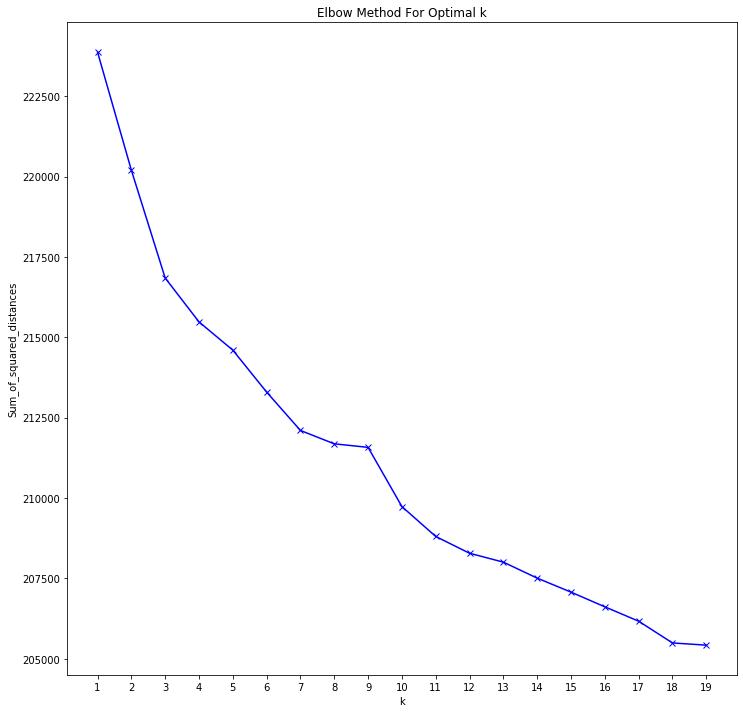

In [21]:
plt.figure(figsize=(12, 12))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1,20))
plt.show()

In [ ]:
from sklearn.cluster import KMeans
km_model = KMeans(n_clusters=9,random_state = seed,n_jobs=-1)
km_model.fit(train_vect)

In [ ]:
cluster_labels_tfidf = km_model.labels_
cluster_labels_tfidf = pd.DataFrame(cluster_labels_tfidf, columns=['kmeans_tfidf_cluster'])

In [29]:
cluster_labels_tfidf.to_csv('../data/train_kmeans_tfidf_cluster.csv',index=False,header=True)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',ngram_range=(1,1))
test_vect = tfidf.fit_transform(test['descripcion'])

In [22]:
from sklearn.cluster import KMeans
km_model_test = KMeans(n_clusters=9,random_state = seed,n_jobs=-1)
km_model_test.fit(test_vect)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [23]:
cluster_labels_tfidf_test = km_model_test.labels_
cluster_labels_tfidf_test = pd.DataFrame(cluster_labels_tfidf_test, columns=['kmeans_tfidf_cluster'])

In [26]:
cluster_labels_tfidf_test.to_csv('../data/test_kmeans_tfidf_cluster.csv',index=False,header=True)

## Word2Vec + Affinity propagation as cluster

In [68]:
import matplotlib.pyplot as plt

In [69]:
from gensim.models import word2vec
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(descripcion) for descripcion in train.descripcion[:100]]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
                              
                              
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 149 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 146 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/fabrizio/anaconda

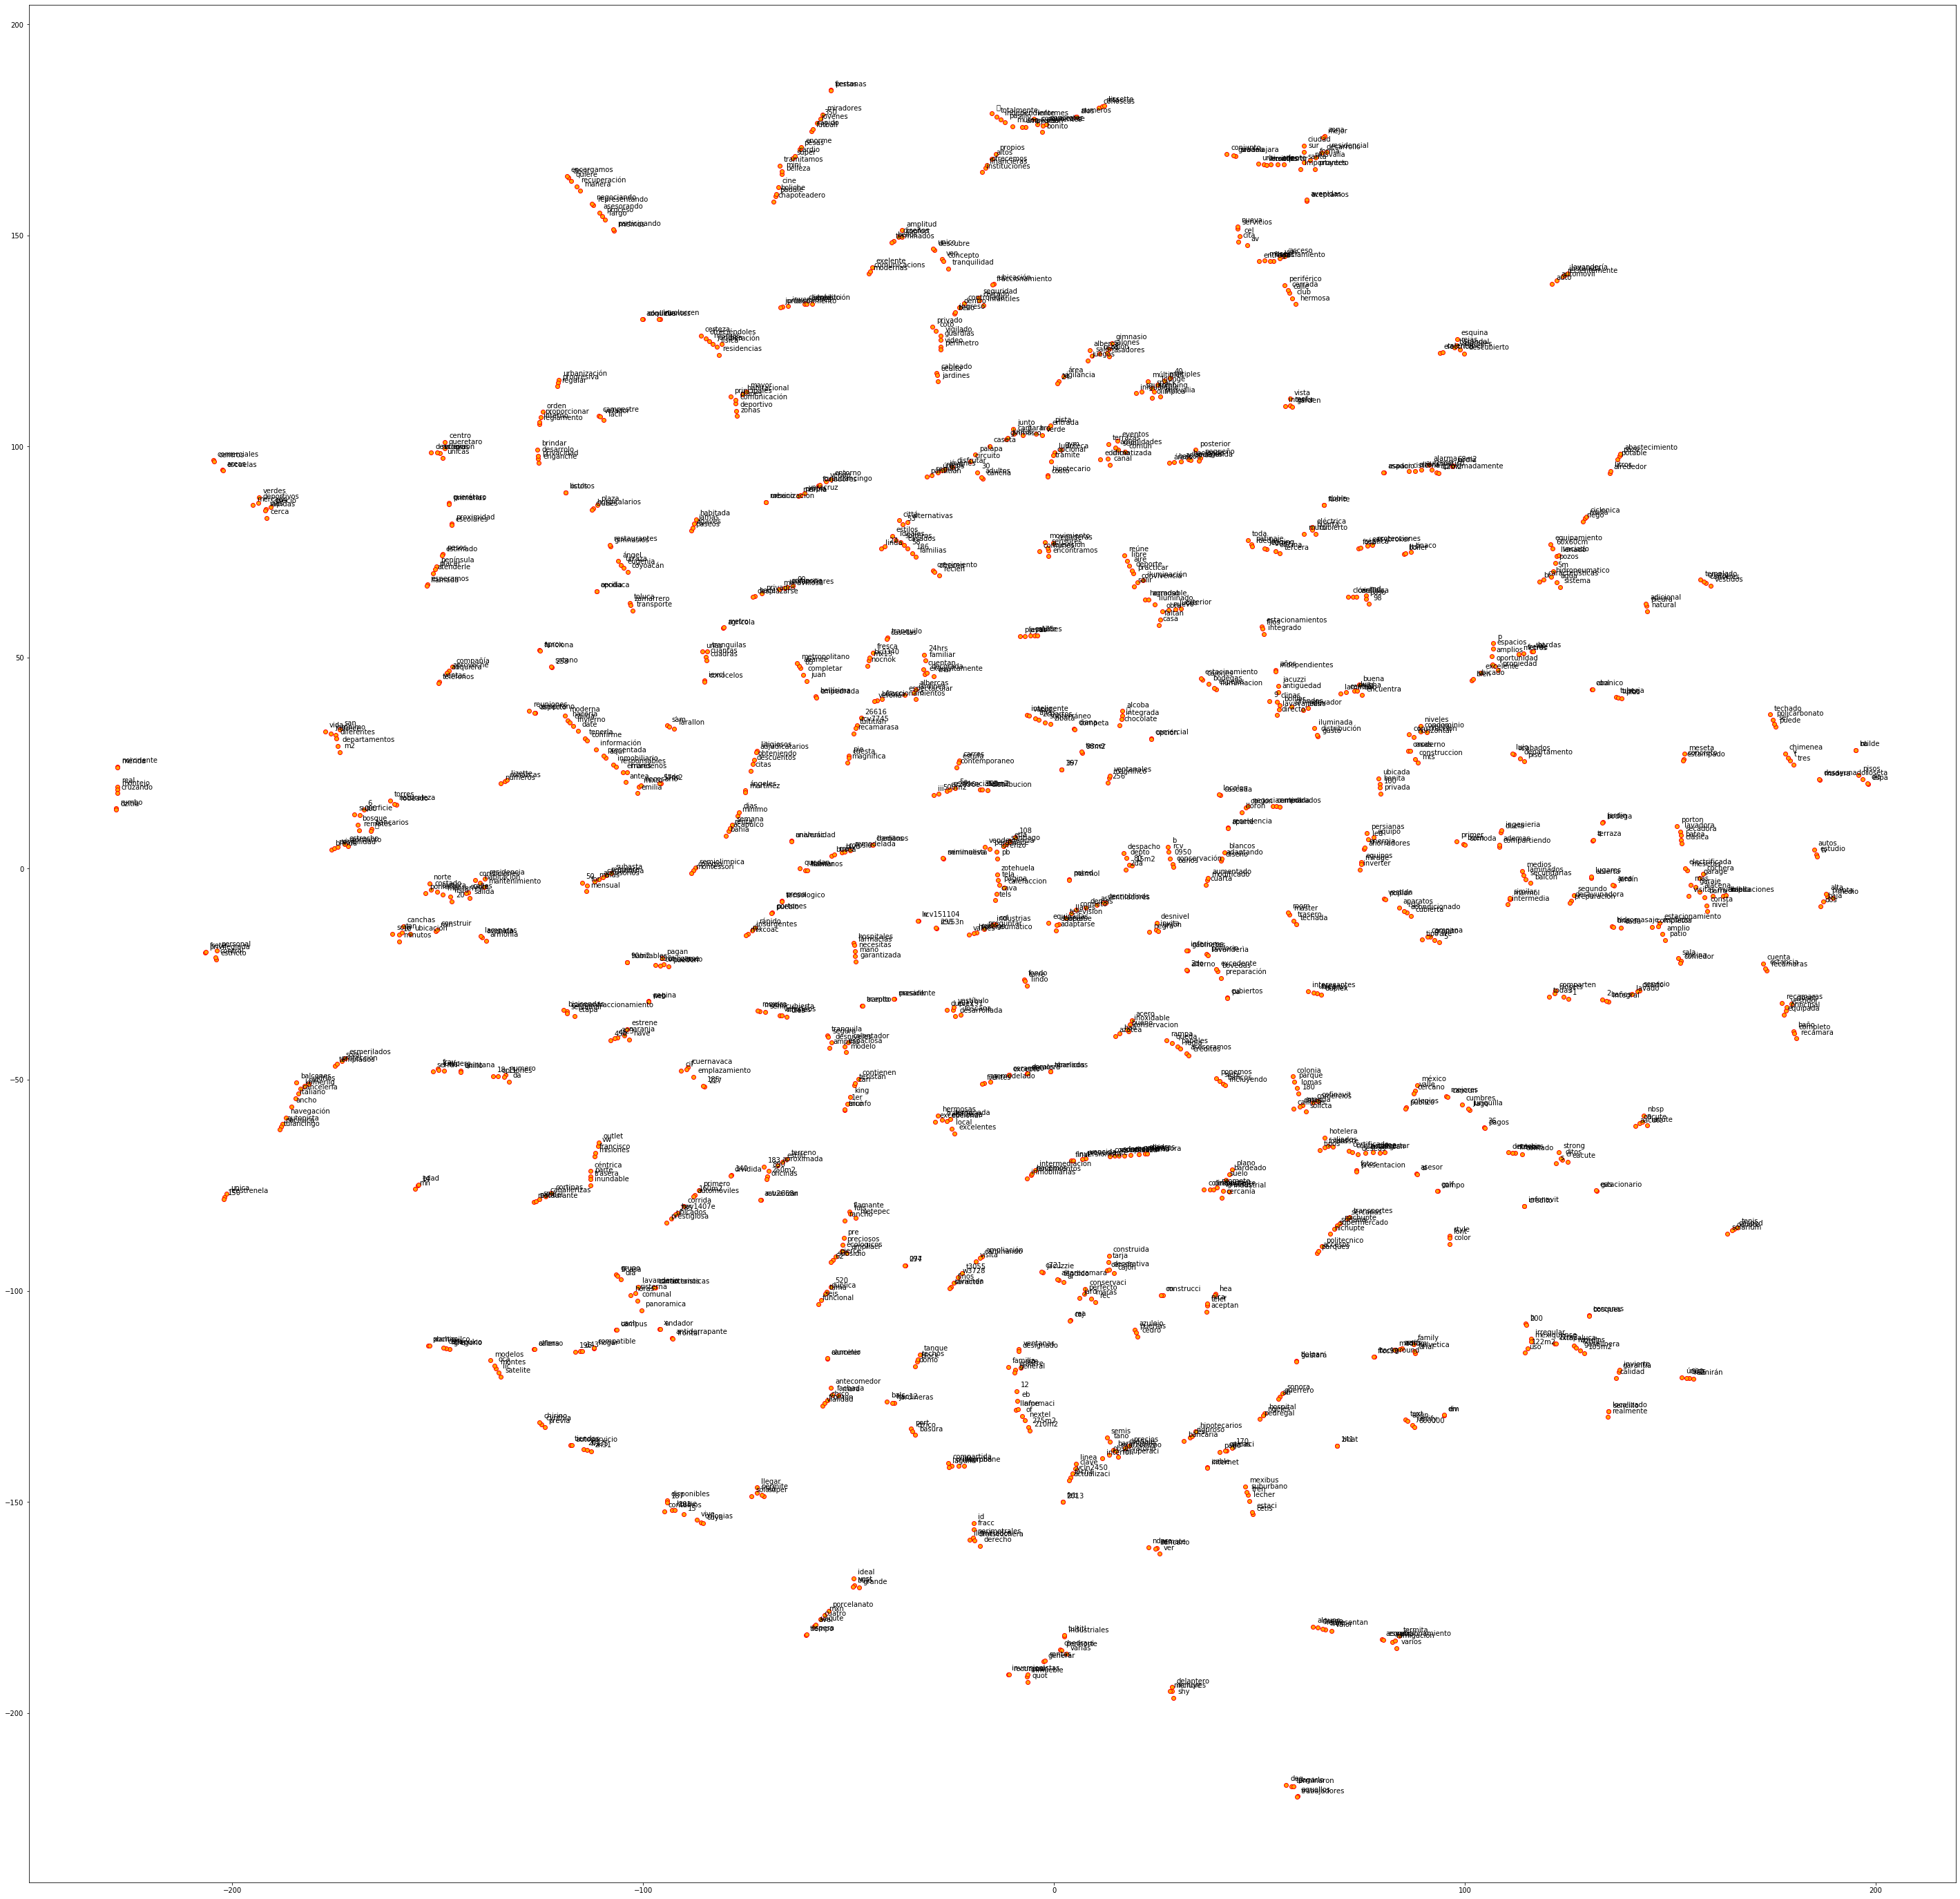

In [18]:
plt.figure(figsize=(50, 50))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [70]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(df, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in df]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(df=train.descripcion[:100], model=w2v_model,
                                             num_features=feature_size)

/home/fabrizio/anaconda3/envs/tester/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [71]:
w2v_feature_array = pd.DataFrame(w2v_feature_array)

In [76]:
w2v_feature_array

,0,1,2,3,4,5,6,7,8,9
0,-0.000426,-3.061254,-0.357759,-1.472734,-1.483838,-0.174005,2.083344,0.907974,0.443441,-0.411161
1,0.298161,-2.903484,-0.697259,-1.596463,-1.803708,0.080619,2.135291,1.180087,0.028581,-0.971892
2,0.272148,-2.260292,-0.415337,-1.468783,-2.077056,0.511980,2.410289,1.450605,-0.512209,-1.113186
3,0.463903,-2.277293,-0.868438,-1.368972,-1.735277,0.246278,1.771792,0.993406,-0.257896,-1.053735
4,0.617336,-2.317957,-0.949597,-1.489865,-1.827349,0.203684,2.175853,1.320825,-0.973892,-1.428871
...,...,...,...,...,...,...,...,...,...,...
95,0.588567,-2.300036,-0.855823,-1.245916,-1.662390,-0.023335,2.173708,1.002438,-0.634950,-0.902515
96,0.194147,-3.351625,-0.436764,-1.983279,-1.805449,-0.071112,2.084036,1.070907,0.631615,-0.814018
97,0.671315,-2.522487,-0.930337,-1.640019,-1.894033,0.117248,2.302800,1.282675,-0.467300,-1.128256
98,0.223460,-2.740310,-0.598314,-1.724545,-1.821882,-0.031080,1.821434,1.085616,0.367955,-0.796679


In [83]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(preference=-9)
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])

In [85]:
train.shape

(240000, 57)

In [84]:
cluster_labels.ClusterLabel.value_counts()

0    50
3    35
1    14
2     1
Name: ClusterLabel, dtype: int64

In [75]:
cluster_labels_tfidf

,kmeans_tfidf_cluster
0,1
1,7
2,3
3,3
4,0
...,...
239995,6
239996,1
239997,0
239998,3


### No da la RAM para todo el set, se necesitarian 19 GB para este algoritmo

- https://stackoverflow.com/questions/35901718/sklearn-affinitypropagation-memoryerror

## GloVe Model

In [18]:
import es_core_news_md
nlp = es_core_news_md.load()                

In [19]:
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 20000


In [35]:
unique_words = list(set([word for sublist in [doc.split() for doc in train.descripcion] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
df_word_glove_vectors = pd.DataFrame(word_glove_vectors, index=unique_words)

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

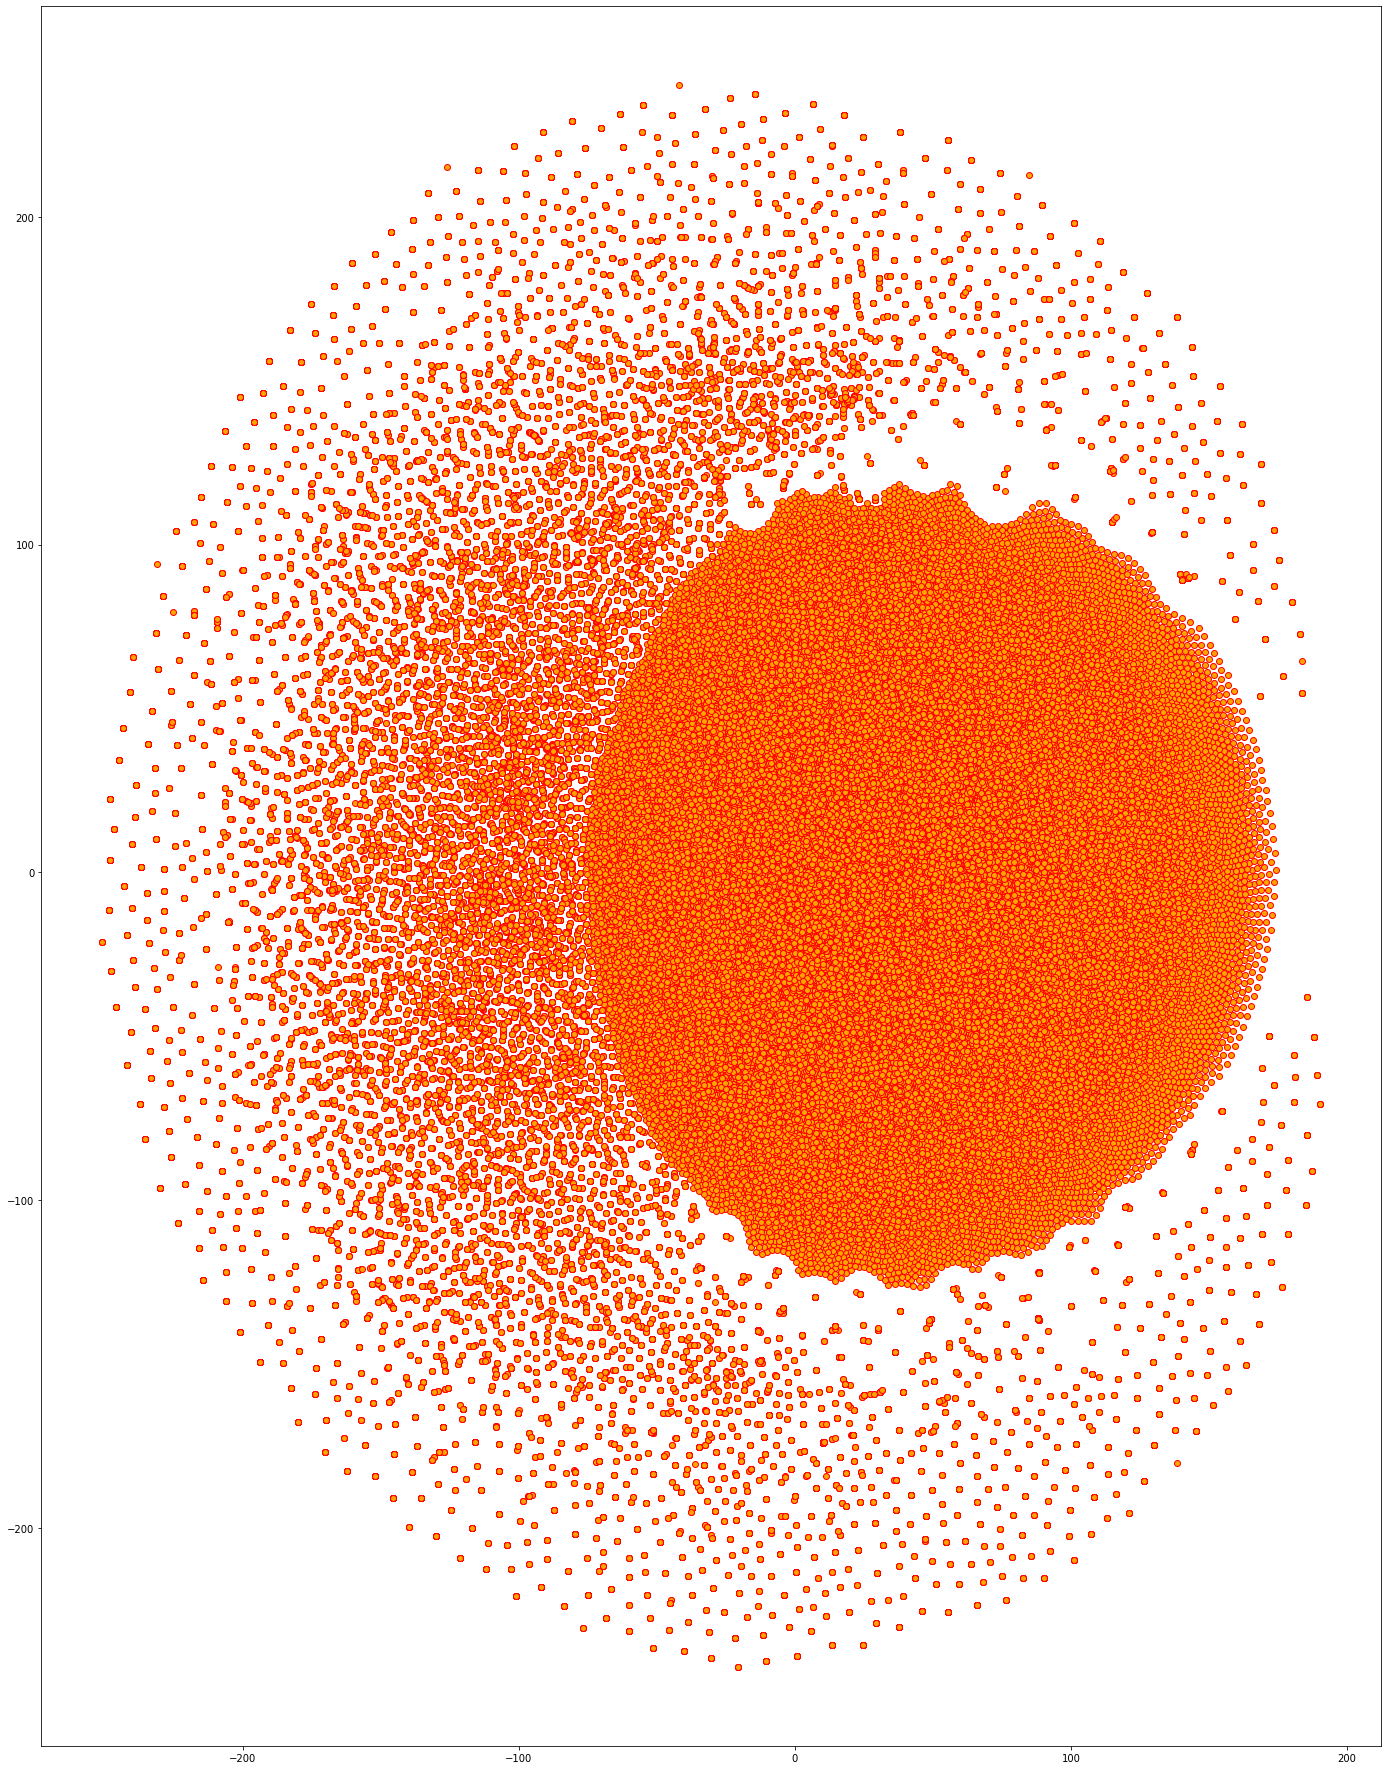

In [50]:
plt.figure(figsize=(24, 32))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate("", xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [38]:
from sklearn.cluster import MiniBatchKMeans

In [20]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in train.descripcion])

In [40]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = MiniBatchKMeans(n_clusters=k,random_state=seed,batch_size=10000)
    kmeanModel.fit(doc_glove_vectors)
    distortions.append(kmeanModel.inertia_)

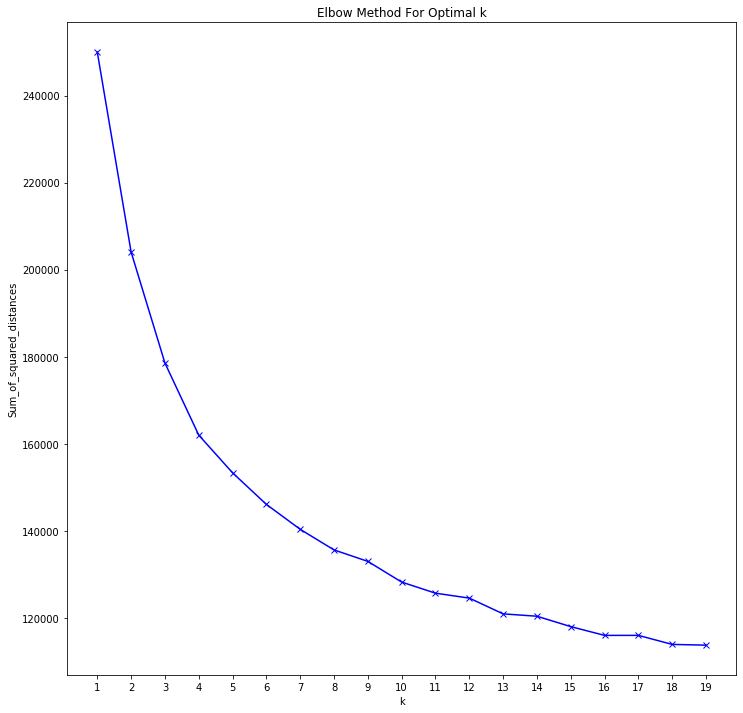

In [41]:
plt.figure(figsize=(12, 12))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1,20))
plt.show()

In [21]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=9,random_state = seed,n_jobs=-1)
km.fit_transform(doc_glove_vectors)

array([[0.9930975 , 0.8390721 , 1.3604356 , ..., 1.9735427 , 1.8827751 ,
        1.3188405 ],
       [1.3012035 , 1.024117  , 0.9216225 , ..., 0.9585257 , 1.457369  ,
        1.0784011 ],
       [1.0224602 , 0.8050519 , 0.66708946, ..., 1.3764874 , 0.86289877,
        0.4770656 ],
       ...,
       [0.87495697, 0.47951934, 0.71029866, ..., 1.5518303 , 1.3516817 ,
        0.73683196],
       [0.92097974, 1.0457647 , 1.3819066 , ..., 1.9148045 , 1.4919457 ,
        1.0783472 ],
       [1.4150441 , 0.9097042 , 0.5742303 , ..., 1.2914548 , 1.5889735 ,
        1.0630476 ]], dtype=float32)

In [22]:
cluster_labels_glove = km.labels_
cluster_labels_glove = pd.DataFrame(cluster_labels_glove, columns=['kmeans_glove_cluster'])

In [23]:
cluster_labels_glove.to_csv('../data/train_kmeans_glove_cluster.csv',index=False,header=True)

In [45]:
doc_glove_vectors_test = np.array([nlp(str(doc)).vector for doc in test.descripcion])

In [46]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=9,random_state = seed,n_jobs=-1)
km.fit_transform(doc_glove_vectors_test)

array([[1.4892222 , 3.362454  , 2.009509  , ..., 1.7305048 , 1.8666118 ,
        1.7082257 ],
       [0.6112436 , 2.2633517 , 0.83245504, ..., 0.9793255 , 1.4405688 ,
        1.6888056 ],
       [1.0951579 , 2.214476  , 0.7278581 , ..., 0.82664585, 1.3340483 ,
        1.6080313 ],
       ...,
       [1.2398129 , 3.0484793 , 1.347471  , ..., 0.809126  , 1.3190101 ,
        0.9803617 ],
       [1.2761422 , 3.0595105 , 1.3627483 , ..., 0.83804774, 1.3729953 ,
        0.97917587],
       [1.2235515 , 2.5946739 , 1.7461524 , ..., 1.9122962 , 2.0006278 ,
        2.3673384 ]], dtype=float32)

In [47]:
cluster_labels_glove_test = km.labels_
cluster_labels_glove_test = pd.DataFrame(cluster_labels_glove_test, columns=['kmeans_glove_cluster'])

In [48]:
cluster_labels_glove_test.to_csv('../data/test_kmeans_glove_cluster.csv',index=False,header=True)

In [91]:
cluster_labels_glove_test.kmeans_glove_cluster

0        0
1        0
2        4
3        3
4        0
        ..
59995    8
59996    3
59997    3
59998    3
59999    5
Name: kmeans_glove_cluster, Length: 60000, dtype: int32